# Fig. 5: Phosphene alignment with the axon map

In [1]:
import os
import numpy as np
import pandas as pd

import argus_shapes

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline
plt.style.use('seaborn-colorblind')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-08-05 18:18:23,951 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
datafolder = os.environ['ARGUS_SHAPES_DATA']
subjectdata = argus_shapes.load_subjects(os.path.join(datafolder, 'subjects.csv'))
subjectdata['scale'] = pd.Series([2.5, 2.5, 2.5, 2.5], index=subjectdata.index)
subjects = subjectdata.index.sort_values()

In [3]:
n_shuffle = 1000
alpha = 0.05

In [4]:
Xy = argus_shapes.load_data(os.path.join(datafolder, 'drawings_single.csv'))

In [5]:
# Don't binarize (thresh=False), don't exclude inconsistent mean drawings (max_area=inf):
Xymu = argus_shapes.calc_mean_images(Xy, thresh=False, max_area=np.inf)

In [6]:
def calc_tangent(xc, yc, model, bundles):
    axon = model._finds_closest_axons(bundles, xret=xc, yret=yc)[0]
    idx = np.argmin((axon[:, 0] - xc) ** 2 + (axon[:, 1] - yc) ** 2)
    if idx == 0:
        dx = axon[1, :] - axon[0, :]
    elif idx == axon.shape[0] - 1:
        dx = axon[-1, :] - axon[-2, :]
    else:
        dx = (axon[idx + 1, :] - axon[idx - 1, :]) / 2
    
    dx[1] *= -1
    tangent = np.arctan2(*dx[::-1])
    if tangent < np.deg2rad(-90):
        tangent += np.deg2rad(180)
    if tangent > np.deg2rad(90):
        tangent -= np.deg2rad(180)
    return tangent

In [7]:
def shuffle_test(subject, Xy, subjectdata, n_iter=10, alpha=0.05, random_state=42):
    """Resample analysis"""
    np.random.seed(random_state)
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot)
    model = argus_shapes.models.ModelC(engine='cython')
#     model.fit(pd.DataFrame(Xy))
    model.fit(pd.DataFrame([{'electrode': 'A01'}]))
    bundles = model._grows_axon_bundles()
    x_center = [implant[row['electrode']].x_center for (_, row) in Xy.iterrows()]
    y_center = [implant[row['electrode']].y_center for (_, row) in Xy.iterrows()]
    
    angles_true = [
        np.abs(np.rad2deg(argus_shapes.utils.angle_diff(
            row['orientation'],
            calc_tangent(xc, yc, model, bundles)
        )))
        for (_, row), xc, yc in zip(Xy.iterrows(), x_center, y_center)
    ]
    angles_random = []
    for _ in range(n_iter):
        x_center = np.random.rand(Xy.shape[0]) * 16000 - 8000
        y_center = np.random.rand(Xy.shape[0]) * 8000 - 4000
        angles_random.append([
            np.abs(np.rad2deg(argus_shapes.utils.angle_diff(
                row['orientation'],
                calc_tangent(xc, yc, model, bundles)
            )))
            for (_, row), xc, yc in zip(Xy.iterrows(), x_center, y_center)
        ])
    is_better = [np.mean(a) for a in angles_random] < np.mean(angles_true)
    is_signif = np.sum(is_better) < alpha * n_iter
    return is_signif, angles_true, angles_random

In [8]:
def plot_box(angles_true, angles_random, is_signif, ax):
    ax.boxplot([angles_true, angles_random], widths=0.7)
    x1, x2 = 1, 2
    y, h, col = np.max(angles_random) + 10, 5, 'k'
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)

    if is_signif:
        txt = '*'
    else:
        txt = 'n.s.'
    ax.text((x1+x2)*.5, y+h, txt, ha='center', va='bottom', color=col, fontsize=14)
    ax.set_ylabel('|$\Delta$ angle| (deg)')
    ax.set_yticks(np.linspace(0, 180, 5))
    ax.set_xticklabels(['drawings', 'shuffled'])

In [9]:
import pulse2percept as p2p
from matplotlib import patches
def plot_orientation(subject, y_mean, subjectdata, ax):
    implant_type = subjectdata.loc[subject, 'implant_type']
    implant_rot = subjectdata.loc[subject, 'implant_rot']
    implant = implant_type(x_center=subjectdata.loc[subject, 'implant_x'], 
                           y_center=subjectdata.loc[subject, 'implant_y'],
                           rot=implant_rot)
    sim = p2p.Simulation(implant)
    sim.set_optic_fiber_layer(sampling=500, n_rho=71, n_axons=301, x_range=(0, 0), y_range=(0, 0),
                              rho_range=(2, 45),
                              loc_od=(subjectdata.loc[subject, 'loc_od_x'], 
                                      subjectdata.loc[subject, 'loc_od_y']))
    sim.plot_fundus(ax=ax, annotate=True, upside_down=True)
    if isinstance(implant, p2p.implants.ArgusII):
        patch = patches.Rectangle((implant['A1'].x_center-400, implant['A1'].y_center-200),
                                  525*9+800, 525*5+800, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    else:
        patch = patches.Rectangle((implant['A1'].x_center-700, implant['A1'].y_center+300),
                                  900*4, 900*4, color='gray', alpha=0.5,
                                  angle=np.rad2deg(implant_rot), zorder=10)
    ax.add_patch(patch)
    for _, row in y_mean.iterrows():
        ax.quiver(implant[row['electrode']].x_center, implant[row['electrode']].y_center,
                  np.cos(row['orientation']), np.sin(row['orientation']), width=0.01,
                  color='w', zorder=100, headlength=0, headwidth=1, pivot='middle')
    ax.set_title(subject)
    ax.set_xlim(-5000, 6000)
    ax.set_ylim(3000, -4000)
    # Plot optic nerve head:
    x_od = argus_shapes.utils.dva2ret(subjectdata.loc[subject, 'loc_od_x'])
    y_od = argus_shapes.utils.dva2ret(subjectdata.loc[subject, 'loc_od_y'])
    ax.add_patch(patches.Circle((x_od, y_od), radius=900, alpha=1, color='black', zorder=100))
    # Remove annotations:
    for t in ax.texts:
        if 'temporal' in t.get_text() or 'nasal' in t.get_text():
            t.set_visible(False)
    # Plot scale bar:
    ax.plot([-3000, -2000], [2500, 2500], 'w', linewidth=3)
    ax.text(-2500, 2500, '1mm', ha='center', va='bottom', color='white')

In [10]:
def plot_drawing(ax, image, electrode=None, scale=1):
    img_avg = argus_shapes.imgproc.center_phosphene(image)
    img_avg = argus_shapes.imgproc.scale_phosphene(img_avg, scale)
    ax.imshow(1 - img_avg, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    if electrode is not None:
        a = ax.axis()
        ax.text(a[0], a[3], electrode, ha='left', va='top',
                bbox=dict(boxstyle='square,pad=0.5', fc='white', ec='black'))

def plot_insets(ax, Xy, electrodes, scale):
    assert len(electrodes) == 3
    for electrode, loc in zip(electrodes, [1, 5, 4]):
        axins = inset_axes(ax, width='30%', height='30%', loc=loc)
        plot_drawing(axins, Xy[Xy.electrode == electrode].image.values[0], electrode, scale)

In [11]:
is_signif = {}
angles_true = {}
angles_random = {}

In [12]:
electrodes = {
    'S1': ['D2', 'C2', 'A4'],
    'S2': ['B9', 'D7', 'E1'],
    'S3': ['F6', 'C6', 'B4'],
    'S4': ['C10', 'F9', 'F2']
}

## Fig. 5A: Subject 1

In [13]:
subject = 'S1'
is_signif[subject], angles_true[subject], angles_random[subject] = shuffle_test(
    subject, Xy[Xy.subject == subject], subjectdata, n_iter=n_shuffle, alpha=alpha
)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


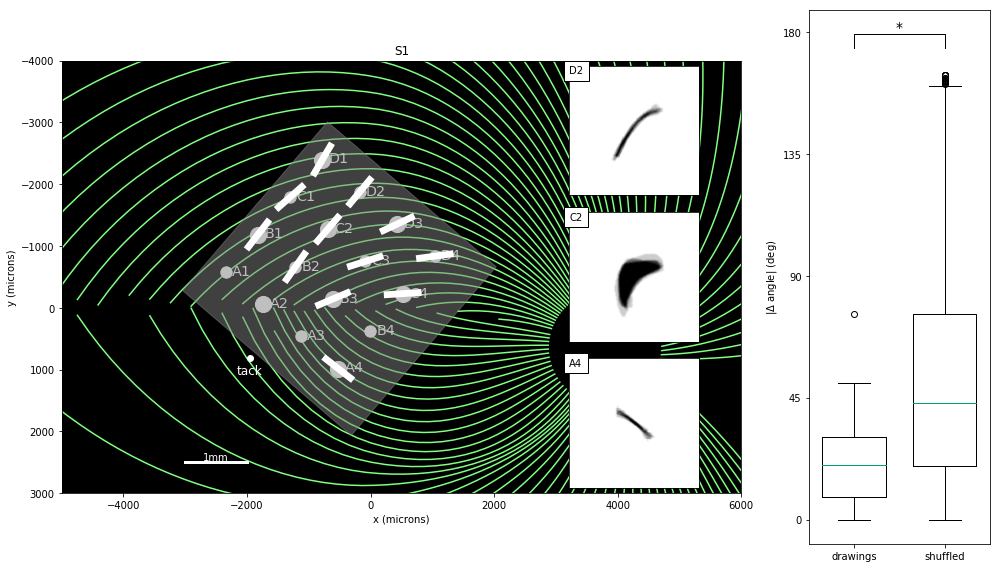

In [14]:
fig = plt.figure(figsize=(14, 8))

# Plot axon map:
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, Xymu[Xymu.subject == subject], subjectdata, ax1)
# Plot example drawings as insets:
plot_insets(ax1, Xymu[Xymu.subject == subject], electrodes[subject], subjectdata.loc['S1', 'scale'])

# Shuffle text box plot:
ax2 = plt.subplot2grid((1, 4), (0, 3))
plot_box(angles_true[subject], angles_random[subject], is_signif[subject], ax2)

fig.tight_layout()
fig.savefig('fig5-%s.eps' % subject)

## Fig. 5B: Subject 2

In [15]:
subject = 'S2'
is_signif[subject], angles_true[subject], angles_random[subject] = shuffle_test(
    subject, Xy[Xy.subject == subject], subjectdata, n_iter=n_shuffle, alpha=alpha
)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


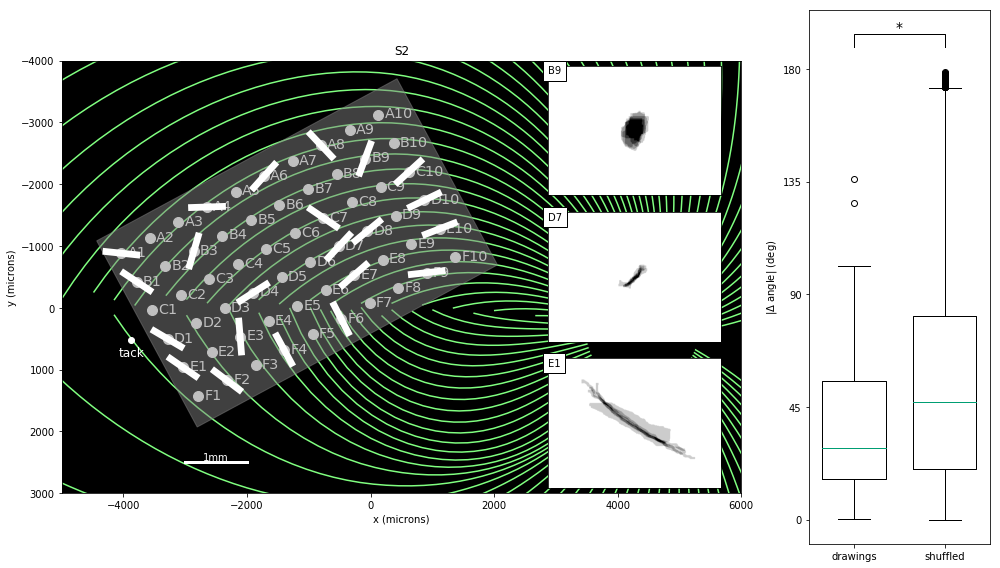

In [16]:
fig = plt.figure(figsize=(14, 8))

# Plot axon map:
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, Xymu[Xymu.subject == subject], subjectdata, ax1)
# Plot example drawings as insets:
plot_insets(ax1, Xymu[Xymu.subject == subject], electrodes[subject], 
            subjectdata.loc[subject, 'scale'])

# Shuffle text box plot:
ax2 = plt.subplot2grid((1, 4), (0, 3))
plot_box(angles_true[subject], angles_random[subject], is_signif[subject], ax2)

fig.tight_layout()
fig.savefig('fig5-%s.eps' % subject)

## Fig. 5C: Subject 3

In [17]:
subject = 'S3'
is_signif[subject], angles_true[subject], angles_random[subject] = shuffle_test(
    subject, Xy[Xy.subject == subject], subjectdata, n_iter=n_shuffle, alpha=alpha
)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


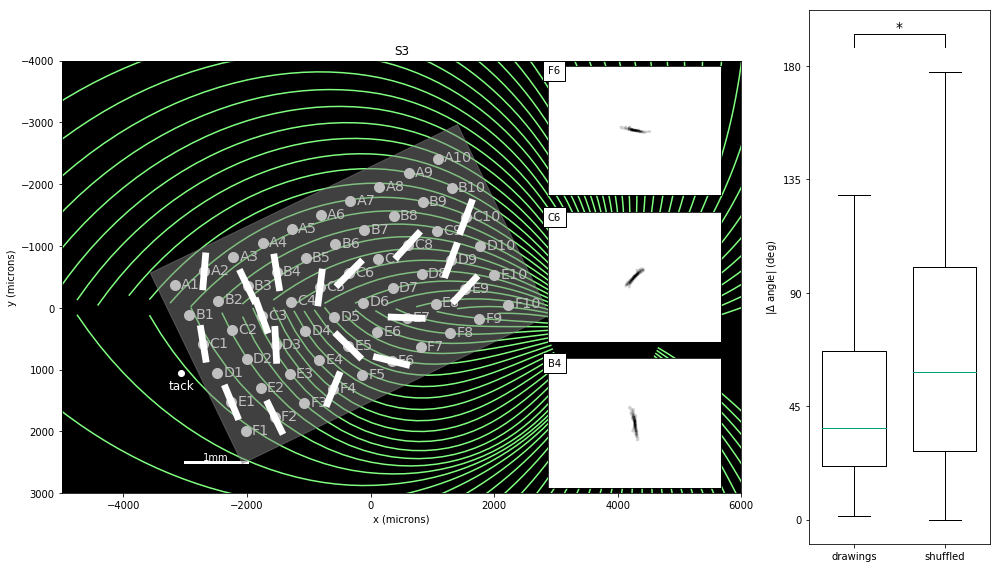

In [ ]:
fig = plt.figure(figsize=(14, 8))

# Plot axon map:
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, Xymu[Xymu.subject == subject], subjectdata, ax1)
# Plot example drawings as insets:
plot_insets(ax1, Xymu[Xymu.subject == subject], electrodes[subject], 
            subjectdata.loc[subject, 'scale'])

# Shuffle text box plot:
ax2 = plt.subplot2grid((1, 4), (0, 3))
plot_box(angles_true[subject], angles_random[subject], is_signif[subject], ax2)

fig.tight_layout()
fig.savefig('fig5-%s.eps' % subject)

## Fig. 5D: Subject 4

In [21]:
subject = 'S4'
is_signif[subject], angles_true[subject], angles_random[subject] = shuffle_test(
    subject, Xy[Xy.subject == subject], subjectdata, n_iter=n_shuffle, alpha=alpha
)

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


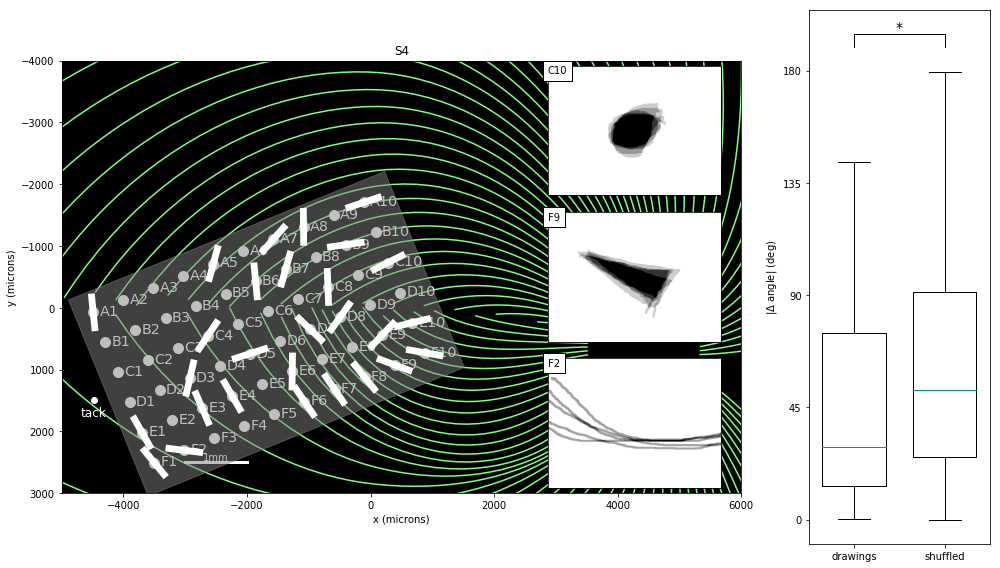

In [22]:
fig = plt.figure(figsize=(14, 8))

# Plot axon map:
ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=3)
plot_orientation(subject, Xymu[Xymu.subject == subject], subjectdata, ax1)
# Plot example drawings as insets:
plot_insets(ax1, Xymu[Xymu.subject == subject], electrodes[subject], 
            subjectdata.loc[subject, 'scale'])

# Shuffle text box plot:
ax2 = plt.subplot2grid((1, 4), (0, 3))
plot_box(angles_true[subject], angles_random[subject], is_signif[subject], ax2)

fig.tight_layout()
fig.savefig('fig5-%s.eps' % subject)